# Znajdowanie skojarzeń

### Omówienie

W poniższej implementacji zakładam, że otrzymujemy na wejściu graf nieskierowany nieważony. W przypadku grafów ważonych, można po prostu zlekceważyć wagi krawędzi, a w przypadku grafów skierowanych, utworzyć na ich podstawie nowy nieskierowany graf nieważony (bo wagi nie mają znaczenia - uznajemy, że każda krawędź ma wagę równą $ 1 $).
###### UWAGA
W tym przypadku nie ma znaczenia, czy użyjemy algorytmu Forda-Fulkersona, czy Edmondsa-Karpa, ponieważ wszystkie wagi krawędzi są równe $ 1 $, więc sumaryczny przepływ nie przekroczy wartości równej liczbie wierzchołków w grafie, a więc otrzymujemy górne ograniczenie równe $ O((V + E) \cdot f^*) = | f^* = O(V), E = O(V^2) | = O(V^2 \cdot V) = O(V^3) $ w przypadku dowolnego algorytmu, który znajduje maksymalny przepływ, na podstawie moetody Forda-Fulkersona, a więc także w przypadku algorytmu Edmondsa-Karpa, którego złożoność określa się na $ O(VE^2) $, w tym przypadku będzie równa $ O(V^3) $, ponieważ zawsze górnym ograniczeniem na złożoność tego algorytmu, jest złożoność algorytmu Forda-Fulkersona.

### Złożoność

###### UWAGA
Możemy założyć, że zawsze $ E = O(V^2) $, ponieważ sieć residualna jest reprezentowana przez graf w postaci macierzowej, a więć przejście przez taki graf ma złożoność $ O(V^2) $, a maksymalnie przejdziemy $ O(V) $ razy, bo taka jest wartość maksymalnego przepływu.
###### Dla wersji z algorytmem Forda-Fulkersona
$ f^* = O(V) \rightarrow O((V + E) \cdot f^*) = O((V + E)V) = | E = O(V^2) | = O(V^3) $
###### Dla wersji z algorytmem Edmondsa-Karpa
$ O(V^3) $

# Gorsza wersja - z wykorzystaniem zmodyfikowanej wersji algorytmu dla grafów skierowanych

## Tylko znajdowanie liczby krawędzi w maksymalnym skojarzeniu

### Implementacja #1
#### (Przy pomocy algorytmu Edmondsa-Karpa)
##### (Dla grafów w postaci listowej)

In [1]:
from queue import Queue


def colorize_vertices(G):
    n = len(G)
    
    # 0 means no color (we will use 2 colors as we want to divide vertices 
    # into two disjoint sets)
    colors = [0] * n  
    
    def dfs(u):
        for v in G[u]:
            if not colors[v]:
                colors[v] = -1 * colors[u]
                if not dfs(v): return False
            elif colors[v] == colors[u]:
                return False
        return True

    for u in range(n):
        if not colors[u]:
            colors[u] = 1
            if not dfs(u): return []  # Return an empty list if a graph is not bipartite

    return colors


def add_source_and_sink(G, colors):
    n = len(G)
    m = len(colors)
    
    # Add a source and a sink
    G.append([])
    G.append([])
    
    for u in range(m):
        # Add outgoing edges from a source to all vertices of a color 1
        if colors[u] == 1:
            G[n].append((u, 1))
        # Add ingoing edges to the sing from all vertices of a color -1
        else:
            G[u].append((n + 1, 1))


def map_graph(G: 'graph represented by adjacency lists'):
    n = len(G)
    G2 = [[] for _ in range(n)]
    w = n
        
    for u in range(n):
        for v in G[u]:
            if u < v:
                G2.append([])
                G2[u].append((w, 1))
                G2[w].append((v, 1))
                w += 1
            else:
                G2[u].append((v, 1))
                    
    return G2
    

def add_back_edges(G):
    n = len(G)
    counts = [0] * n  # Numbers of edges in an initial graph (before modification)
    
    for u in range(n):
        counts[u] = len(G[u])
        
    for u in range(n):
        for i in range(counts[u]):
            v = G[u][i][0]
            G[v].append((u, 0))  # Add an edge with no weight
            

def ford_fulkerson(G: 'graph represented by adjacency lists', s: 'source vertex', t: 'target vertex'):
    n = len(G)
    inf = float('inf')
    flow     = [[0] * n for _ in range(n)]
    visited  = [0] * n
    token    = 1  # Number of iteration to check which vertices have been visited
    
    def dfs(u):
        visited[u] = token
        
        if u == t: return 1
        
        for v, capacity in G[u]:
            remaining = capacity - flow[u][v]
            if visited[v] != token and remaining == 1:
                if dfs(v):
                    flow[u][v] += 1
                    flow[v][u] -= 1
                    return 1
        return 0
    
    while dfs(s):
        token += 1
        
    return token - 1


def maximum_association(G: 'undirected graph represented by adjacency lists'):
    colors = colorize_vertices(G)
    # If a graph is not bipartite, return -1
    if not colors: return -1
    G2 = map_graph(G)
    n = len(G2)
    add_back_edges(G2)
    add_source_and_sink(G2, colors)
    return ford_fulkerson(G2, n, n + 1)

###### Kika testów

##### Pomocnicze

In [2]:
def undirected_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append(e[1])
        G[e[1]].append(e[0])
    return G

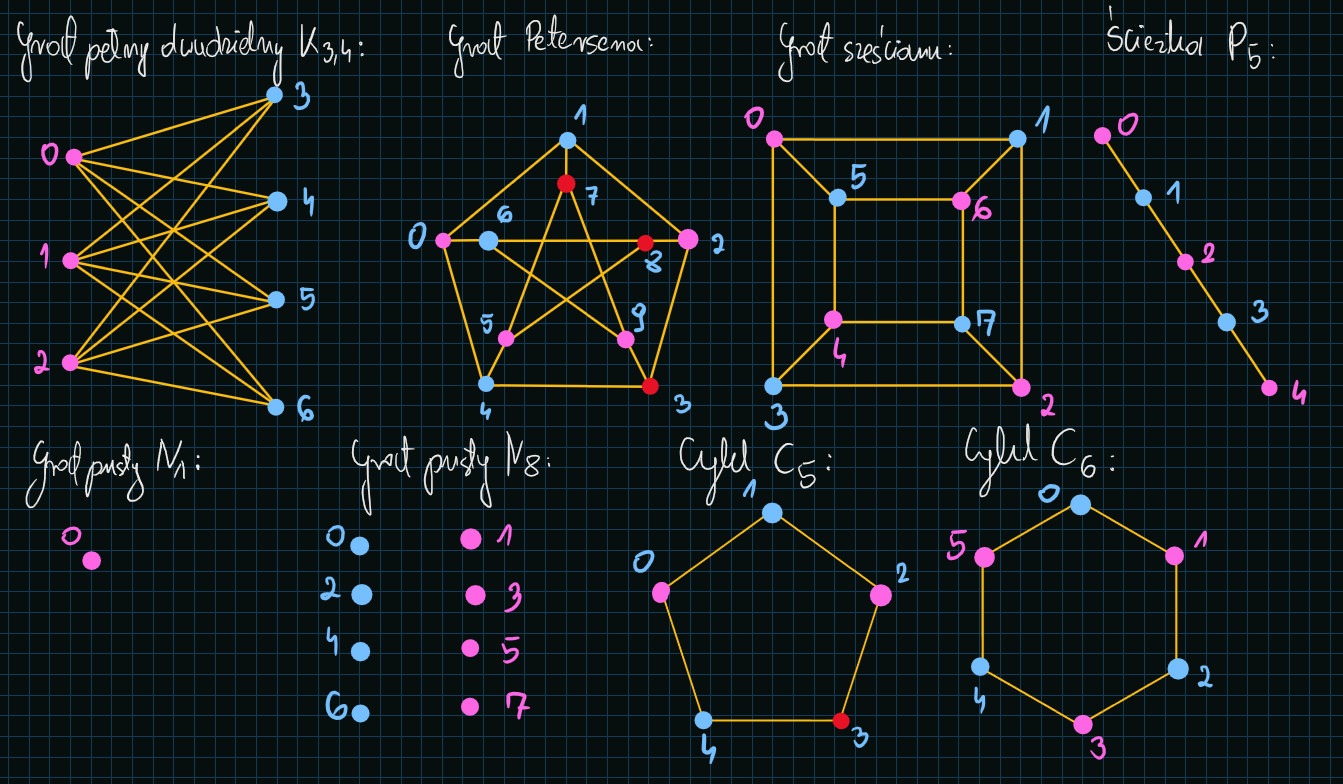

##### Pełny dwudzielny $ K_{3,4} $:

In [3]:
E = [(i, j) for i in range(3) for j in range(3, 7)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[3, 4, 5, 6]
[3, 4, 5, 6]
[3, 4, 5, 6]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
3


##### Graf Petersena:

In [4]:
E = [(0, 1), (0, 6), (0, 4), (1, 7), (1, 2), (2, 8), (2, 3), (3, 4), 
     (3, 9), (4, 5), (6, 8), (8, 5), (5, 7), (7, 9), (9, 6)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 6, 4]
[0, 7, 2]
[1, 8, 3]
[2, 4, 9]
[0, 3, 5]
[4, 8, 7]
[0, 8, 9]
[1, 5, 9]
[2, 6, 5]
[3, 7, 6]
-1


##### Graf sześcianu (kostka $ Q_3 $):

In [5]:
E = [(0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4), (0, 5), (1, 6), (2, 7), (3, 4)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 3, 5]
[0, 2, 6]
[1, 3, 7]
[2, 0, 4]
[5, 7, 3]
[4, 6, 0]
[5, 7, 1]
[6, 4, 2]
4


##### Ścieżka $ P_5 $:

In [6]:
E = [(i, i + 1) for i in range(4)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1]
[0, 2]
[1, 3]
[2, 4]
[3]
2


##### Ścieżka $ P_6 $:

In [7]:
E = [(i, i + 1) for i in range(5)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1]
[0, 2]
[1, 3]
[2, 4]
[3, 5]
[4]
3


##### Cykl $ C_5 $:

In [8]:
E = [(i, (i + 1) % 5) for i in range(5)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 4]
[0, 2]
[1, 3]
[2, 4]
[3, 0]
-1


##### Cykl $ C_6 $:

In [9]:
E = [(i, (i + 1) % 6) for i in range(6)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 5]
[0, 2]
[1, 3]
[2, 4]
[3, 5]
[4, 0]
3


### Implementacja #2
#### (Przy pomocy algorytmu Edmondsa-Karpa)
##### (Dla grafów w postaci listowej)

In [10]:
from queue import Queue


def colorize_vertices(G):
    n = len(G)
    
    # 0 means no color (we will use 2 colors as we want to divide vertices 
    # into two disjoint sets)
    colors = [0] * n  
    
    def dfs(u):
        for v in G[u]:
            if not colors[v]:
                colors[v] = -1 * colors[u]
                if not dfs(v): return False
            elif colors[v] == colors[u]:
                return False
        return True

    for u in range(n):
        if not colors[u]:
            colors[u] = 1
            if not dfs(u): return []  # Return an empty list if a graph is not bipartite

    return colors


def add_source_and_sink(G, colors):
    n = len(G)
    m = len(colors)
    
    # Add a source and a sink
    G.append([])
    G.append([])
    
    for u in range(m):
        # Add outgoing edges from a source to all vertices of a color 1
        if colors[u] == 1:
            G[n].append((u, 1))
        # Add ingoing edges to the sing from all vertices of a color -1
        else:
            G[u].append((n + 1, 1))


def map_graph(G: 'graph represented by adjacency lists'):
    n = len(G)
    G2 = [[] for _ in range(n)]
    w = n
        
    for u in range(n):
        for v in G[u]:
            if u < v:
                G2.append([])
                G2[u].append((w, 1))
                G2[w].append((v, 1))
                w += 1
            else:
                G2[u].append((v, 1))
                    
    return G2
    

def add_back_edges(G):
    n = len(G)
    counts = [0] * n  # Numbers of edges in an initial graph (before modification)
    
    for u in range(n):
        counts[u] = len(G[u])
        
    for u in range(n):
        for i in range(counts[u]):
            v = G[u][i][0]
            G[v].append((u, 0))  # Add an edge with no weight


def update_flow(flow, parents, t):
    u = t
    
    while parents[u] is not None:
        v = parents[u]
        flow[v][u] += 1
        flow[u][v] -= 1
        u = v


def edmonds_karp(G: 'graph represented by adjacency lists', 
                 s: 'source vertex', 
                 t: 'target vertex'):
    n = len(G)
    inf = float('inf')
    flow     = [[0] * n for _ in range(n)]
    parents  = [None] * n
    visited  = [0] * n
    token    = 1  # Number of iteration to check which vertices have been visited

    while True:
        q = Queue()
        q.put(s)
        visited[s] = token
        found_path = False
        
        while not q.empty():
            u = q.get()
            
            if u == t:
                update_flow(flow, parents, t)
                found_path = True
                break
            
            for v, capacity in G[u]:
                remaining = capacity - flow[u][v]
                if visited[v] != token and remaining > 0:
                    visited[v] = token
                    parents[v] = u
                    q.put(v)
        
        if not found_path: break
        token += 1
        
    return token - 1


def maximum_association(G: 'undirected graph represented by adjacency lists'):
    colors = colorize_vertices(G)
    # If a graph is not bipartite, return -1
    if not colors: return -1
    G2 = map_graph(G)
    n = len(G2)
    add_back_edges(G2)
    add_source_and_sink(G2, colors)
    return edmonds_karp(G2, n, n + 1)

###### Kika testów

##### Pomocnicze

In [11]:
def undirected_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append(e[1])
        G[e[1]].append(e[0])
    return G

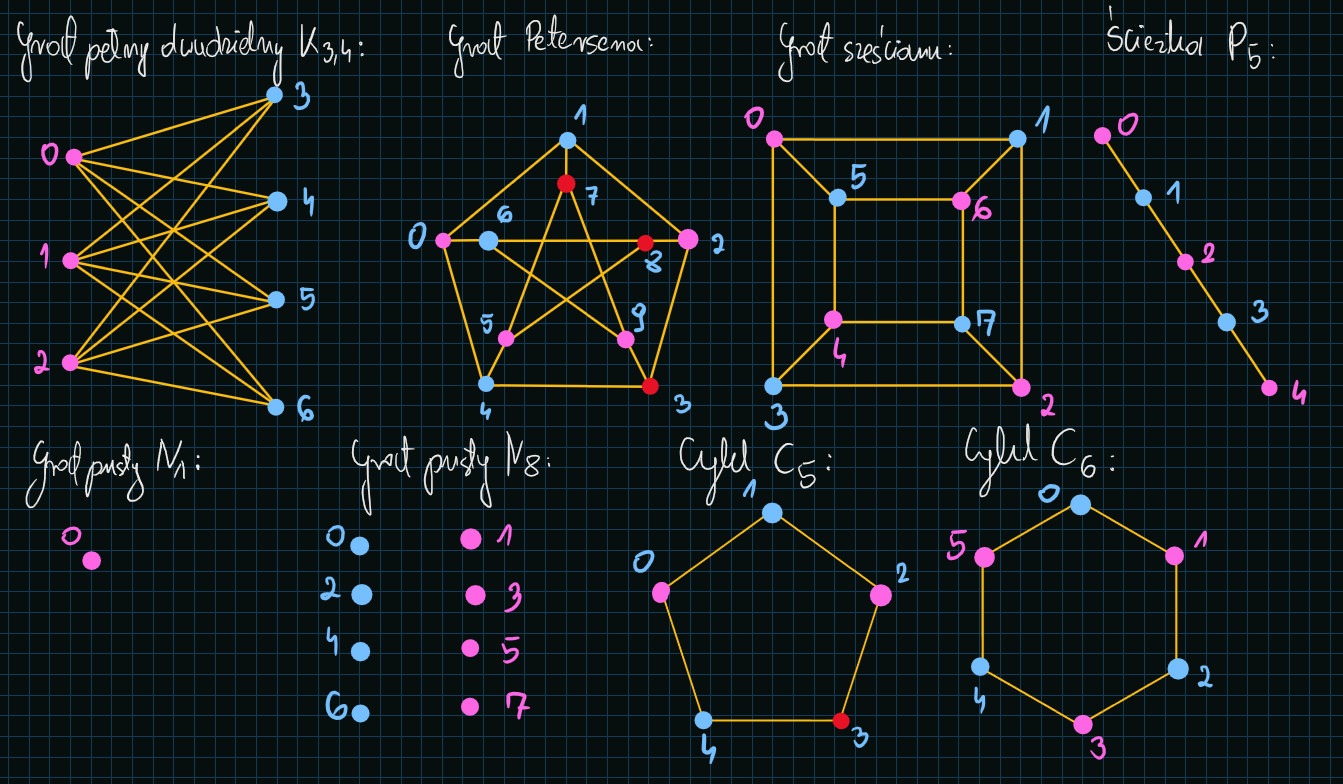

##### Pełny dwudzielny $ K_{3,4} $:

In [12]:
E = [(i, j) for i in range(3) for j in range(3, 7)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[3, 4, 5, 6]
[3, 4, 5, 6]
[3, 4, 5, 6]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
3


##### Graf Petersena:

In [13]:
E = [(0, 1), (0, 6), (0, 4), (1, 7), (1, 2), (2, 8), (2, 3), (3, 4), 
     (3, 9), (4, 5), (6, 8), (8, 5), (5, 7), (7, 9), (9, 6)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 6, 4]
[0, 7, 2]
[1, 8, 3]
[2, 4, 9]
[0, 3, 5]
[4, 8, 7]
[0, 8, 9]
[1, 5, 9]
[2, 6, 5]
[3, 7, 6]
-1


##### Graf sześcianu (kostka $ Q_3 $):

In [14]:
E = [(0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4), (0, 5), (1, 6), (2, 7), (3, 4)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 3, 5]
[0, 2, 6]
[1, 3, 7]
[2, 0, 4]
[5, 7, 3]
[4, 6, 0]
[5, 7, 1]
[6, 4, 2]
4


##### Ścieżka $ P_5 $:

In [15]:
E = [(i, i + 1) for i in range(4)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1]
[0, 2]
[1, 3]
[2, 4]
[3]
2


##### Ścieżka $ P_6 $:

In [16]:
E = [(i, i + 1) for i in range(5)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1]
[0, 2]
[1, 3]
[2, 4]
[3, 5]
[4]
3


##### Cykl $ C_5 $:

In [17]:
E = [(i, (i + 1) % 5) for i in range(5)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 4]
[0, 2]
[1, 3]
[2, 4]
[3, 0]
-1


##### Cykl $ C_6 $:

In [18]:
E = [(i, (i + 1) % 6) for i in range(6)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 5]
[0, 2]
[1, 3]
[2, 4]
[3, 5]
[4, 0]
3


## Znajdowanie krawędzi, które tworzą maksymalne skojarzenie

### Implementacja
#### (Przy pomocy algorytmu Edmondsa-Karpa)
##### (Dla grafów w postaci listowej)

In [19]:
from queue import Queue


def colorize_vertices(G):
    n = len(G)
    
    # 0 means no color (we will use 2 colors as we want to divide vertices 
    # into two disjoint sets)
    colors = [0] * n  
    
    def dfs(u):
        for v in G[u]:
            if not colors[v]:
                colors[v] = -1 * colors[u]
                if not dfs(v): return False
            elif colors[v] == colors[u]:
                return False
        return True

    for u in range(n):
        if not colors[u]:
            colors[u] = 1
            if not dfs(u): return []  # Return an empty list if a graph is not bipartite

    return colors


def add_source_and_sink(G, colors):
    n = len(G)
    m = len(colors)
    
    # Add a source and a sink
    G.append([])
    G.append([])
    
    for u in range(m):
        # Add outgoing edges from a source to all vertices of a color 1
        if colors[u] == 1:
            G[n].append((u, 1))
        # Add ingoing edges to the sing from all vertices of a color -1
        else:
            G[u].append((n + 1, 1))


def map_graph(G: 'graph represented by adjacency lists'):
    n = len(G)
    G2 = [[] for _ in range(n)]
    w = n
        
    for u in range(n):
        for v in G[u]:
            if u < v:
                G2.append([])
                G2[u].append((w, 1))
                G2[w].append((v, 1))
                w += 1
            else:
                G2[u].append((v, 1))
                    
    return G2
    

def add_back_edges(G):
    n = len(G)
    counts = [0] * n  # Numbers of edges in an initial graph (before modification)
    
    for u in range(n):
        counts[u] = len(G[u])
        
    for u in range(n):
        for i in range(counts[u]):
            v = G[u][i][0]
            G[v].append((u, 0))  # Add an edge with no weight
            
    return counts


def update_flow(flow, parents, t):
    u = t
    
    while parents[u] is not None:
        v = parents[u]
        flow[v][u] += 1
        flow[u][v] -= 1
        u = v


def edmonds_karp(G: 'graph represented by adjacency lists', 
                 s: 'source vertex', 
                 t: 'target vertex'):
    n = len(G)
    inf = float('inf')
    flow     = [[0] * n for _ in range(n)]
    parents  = [None] * n
    visited  = [0] * n
    token    = 1  # Number of iteration to check which vertices have been visited

    while True:
        q = Queue()
        q.put(s)
        visited[s] = token
        found_path = False
        
        while not q.empty():
            u = q.get()
            
            if u == t:
                update_flow(flow, parents, t)
                found_path = True
                break
            
            for v, capacity in G[u]:
                remaining = capacity - flow[u][v]
                if visited[v] != token and remaining > 0:
                    visited[v] = token
                    parents[v] = u
                    q.put(v)
        
        if not found_path: break
        token += 1
        
    return flow, token - 1


def get_association(flow: 'flow array returned by the edmonds-karp algorithm', 
                    G: 'mapped graph',
                    n: 'number of vertices in the original graph',
                    counts: 'numbers of neighbours before adding back edges'):
    result = []
    
    for u in range(n):
        for i in range(counts[u]):
            v = G[u][i][0]
            if flow[u][v] == 1:
                if v >= n:
                    v = G[v][0][0]
                result.append((u, v))
    
    return result


def maximum_association(G: 'undirected graph represented by adjacency lists'):
    colors = colorize_vertices(G)
    # If a graph is not bipartite, return -1 and an empty edges list
    if not colors: return -1, []
    G2 = map_graph(G)
    n = len(G2)
    counts = add_back_edges(G2)
    add_source_and_sink(G2, colors)
    flow, count = edmonds_karp(G2, n, n + 1)
    return count, get_association(flow, G2, len(G), counts)

###### Kika testów

##### Pomocnicze

In [20]:
def undirected_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append(e[1])
        G[e[1]].append(e[0])
    return G

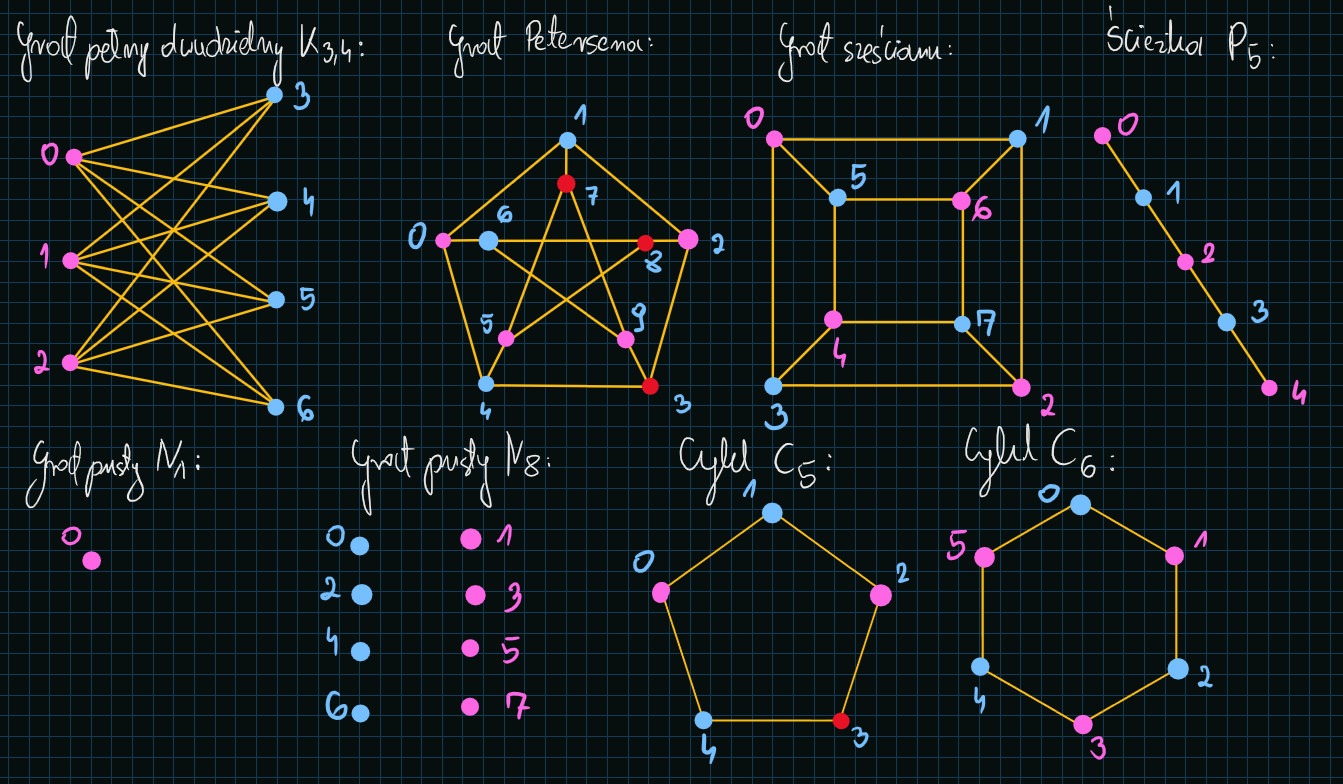

##### Pełny dwudzielny $ K_{3,4} $:

In [21]:
E = [(i, j) for i in range(3) for j in range(3, 7)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[3, 4, 5, 6]
[3, 4, 5, 6]
[3, 4, 5, 6]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
(3, [(0, 3), (1, 4), (2, 5)])


##### Graf Petersena:

In [22]:
E = [(0, 1), (0, 6), (0, 4), (1, 7), (1, 2), (2, 8), (2, 3), (3, 4), 
     (3, 9), (4, 5), (6, 8), (8, 5), (5, 7), (7, 9), (9, 6)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 6, 4]
[0, 7, 2]
[1, 8, 3]
[2, 4, 9]
[0, 3, 5]
[4, 8, 7]
[0, 8, 9]
[1, 5, 9]
[2, 6, 5]
[3, 7, 6]
(-1, [])


##### Graf sześcianu (kostka $ Q_3 $):

In [23]:
E = [(0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4), (0, 5), (1, 6), (2, 7), (3, 4)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 3, 5]
[0, 2, 6]
[1, 3, 7]
[2, 0, 4]
[5, 7, 3]
[4, 6, 0]
[5, 7, 1]
[6, 4, 2]
(4, [(0, 1), (2, 7), (4, 3), (6, 5)])


##### Ścieżka $ P_5 $:

In [24]:
E = [(i, i + 1) for i in range(4)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1]
[0, 2]
[1, 3]
[2, 4]
[3]
(2, [(2, 1), (4, 3)])


##### Ścieżka $ P_6 $:

In [25]:
E = [(i, i + 1) for i in range(5)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1]
[0, 2]
[1, 3]
[2, 4]
[3, 5]
[4]
(3, [(0, 1), (2, 3), (4, 5)])


##### Cykl $ C_5 $:

In [26]:
E = [(i, (i + 1) % 5) for i in range(5)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 4]
[0, 2]
[1, 3]
[2, 4]
[3, 0]
(-1, [])


##### Cykl $ C_6 $:

In [27]:
E = [(i, (i + 1) % 6) for i in range(6)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 5]
[0, 2]
[1, 3]
[2, 4]
[3, 5]
[4, 0]
(3, [(0, 5), (2, 1), (4, 3)])


# Lepsza wersja - z wykorzystaniem algorytmu dostosowanego do grafów nieskierowanych
### (Tak naprawdę, to działa on prawidłowo zarówno dla grafów skierowanych jak i nieskierowanych)

## Tylko znajdowanie liczby krawędzi w maksymalnym skojarzeniu

### Implementacja #1
#### (Przy pomocy algorytmu Edmondsa-Karpa)
##### (Dla grafów w postaci listowej)

In [28]:
from queue import Queue


def colorize_vertices(G):
    n = len(G)
    
    # 0 means no color (we will use 2 colors as we want to divide vertices 
    # into two disjoint sets)
    colors = [0] * n  
    
    def dfs(u):
        for v in G[u]:
            if not colors[v]:
                colors[v] = -1 * colors[u]
                if not dfs(v): return False
            elif colors[v] == colors[u]:
                return False
        return True

    for u in range(n):
        if not colors[u]:
            colors[u] = 1
            if not dfs(u): return []  # Return an empty list if a graph is not bipartite

    return colors


def bfs(G, s, t, parents, visited, token):
    n = len(G)
    q = Queue()
    q.put(s)
    visited[s] = token
    
    while not q.empty():
        u = q.get()
        for v in range(n):
            if not G[u][v] or visited[v] == token: continue
            q.put(v)
            visited[v] = token
            parents[v] = u
    
    return visited[t] == token


def get_bottleneck(G, s, t, parents):
    bottleneck = float('inf')
    u = t
    while u != s:
        bottleneck = min(bottleneck, G[parents[u]][u])
        u = parents[u]
    return bottleneck


def update_flow(G, s, t, parents, bottleneck):
    v = t
    while v != s:
        u = parents[v]
        G[u][v] -= bottleneck
        G[v][u] += bottleneck
        v = parents[v]

        
def create_residual_graph(G, colors):
    n = len(G)
    G2 = [[0] * (n + 2) for _ in range(n + 2)]
    
    # Add residual undirected edges
    for u in range(n):
        for v in G[u]:
            G2[u][v] = 1
    
    # Add directed edges from source to all vertices
    for u in range(n):
        if colors[u] == 1:
            G2[u][n + 1] = 1
        else:
            G2[n][u] = 1
    
    return G2, n, n + 1
    

def edmonds_karp(RG: 'residual graph represented by adjacency matrix', s: 'source vertex', t: 'target vertex'):
    n = len(RG)
    max_flow = 0
    parents = [-1] * n
    visited = [0] * n
    token = 1
    
    while bfs(RG, s, t, parents, visited, token):
        # Find an augmenting path and its bottleneck value
        bottleneck = get_bottleneck(RG, s, t, parents)
        # Update flow on a path which was found
        update_flow(RG, s, t, parents, bottleneck)
        # Increase a value of the maximum flow
        max_flow += bottleneck
        token += 1
            
    return max_flow


def maximum_association(G: 'undirected graph represented by adjacency lists'):
    colors = colorize_vertices(G)
    # If a graph is not bipartite, return -1
    if not colors: return -1
    RG, s, t = create_residual_graph(G, colors)
    return edmonds_karp(RG, s, t)

###### Kika testów

##### Pomocnicze

In [29]:
def undirected_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append(e[1])
        G[e[1]].append(e[0])
    return G

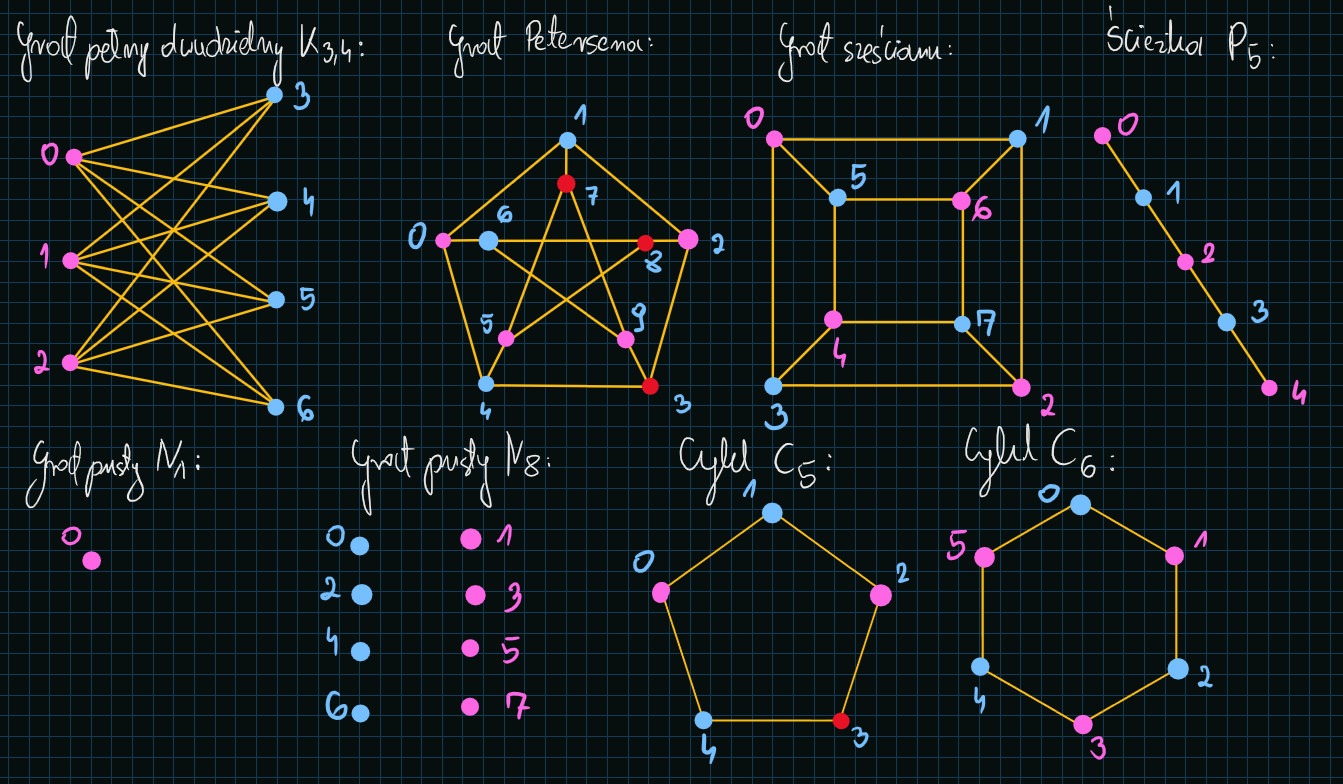

##### Pełny dwudzielny $ K_{3,4} $:

In [30]:
E = [(i, j) for i in range(3) for j in range(3, 7)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[3, 4, 5, 6]
[3, 4, 5, 6]
[3, 4, 5, 6]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
3


##### Graf Petersena:

In [31]:
E = [(0, 1), (0, 6), (0, 4), (1, 7), (1, 2), (2, 8), (2, 3), (3, 4), 
     (3, 9), (4, 5), (6, 8), (8, 5), (5, 7), (7, 9), (9, 6)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 6, 4]
[0, 7, 2]
[1, 8, 3]
[2, 4, 9]
[0, 3, 5]
[4, 8, 7]
[0, 8, 9]
[1, 5, 9]
[2, 6, 5]
[3, 7, 6]
-1


##### Graf sześcianu (kostka $ Q_3 $):

In [32]:
E = [(0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4), (0, 5), (1, 6), (2, 7), (3, 4)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 3, 5]
[0, 2, 6]
[1, 3, 7]
[2, 0, 4]
[5, 7, 3]
[4, 6, 0]
[5, 7, 1]
[6, 4, 2]
4


##### Ścieżka $ P_5 $:

In [33]:
E = [(i, i + 1) for i in range(4)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1]
[0, 2]
[1, 3]
[2, 4]
[3]
2


##### Ścieżka $ P_6 $:

In [34]:
E = [(i, i + 1) for i in range(5)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1]
[0, 2]
[1, 3]
[2, 4]
[3, 5]
[4]
3


##### Cykl $ C_5 $:

In [35]:
E = [(i, (i + 1) % 5) for i in range(5)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 4]
[0, 2]
[1, 3]
[2, 4]
[3, 0]
-1


##### Cykl $ C_6 $:

In [36]:
E = [(i, (i + 1) % 6) for i in range(6)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 5]
[0, 2]
[1, 3]
[2, 4]
[3, 5]
[4, 0]
3


## Znajdowanie liczby krawędzi oraz zwracanie listy krawędzi, które tworzą skojarzenie

### Implementacja #1
#### (Przy pomocy algorytmu Edmondsa-Karpa)
##### (Dla grafów w postaci listowej)

In [37]:
from queue import Queue


def colorize_vertices(G):
    n = len(G)
    
    # 0 means no color (we will use 2 colors as we want to divide vertices 
    # into two disjoint sets)
    colors = [0] * n  
    
    def dfs(u):
        for v in G[u]:
            if not colors[v]:
                colors[v] = -1 * colors[u]
                if not dfs(v): return False
            elif colors[v] == colors[u]:
                return False
        return True

    for u in range(n):
        if not colors[u]:
            colors[u] = 1
            if not dfs(u): return []  # Return an empty list if a graph is not bipartite

    return colors


def bfs(G, s, t, parents, visited, token):
    n = len(G)
    q = Queue()
    q.put(s)
    visited[s] = token
    
    while not q.empty():
        u = q.get()
        for v in range(n):
            if not G[u][v] or visited[v] == token: continue
            q.put(v)
            visited[v] = token
            parents[v] = u
    
    return visited[t] == token


def get_bottleneck(G, s, t, parents):
    bottleneck = float('inf')
    u = t
    while u != s:
        bottleneck = min(bottleneck, G[parents[u]][u])
        u = parents[u]
    return bottleneck


def update_flow(G, s, t, parents, bottleneck):
    v = t
    while v != s:
        u = parents[v]
        G[u][v] -= bottleneck
        G[v][u] += bottleneck
        v = parents[v]

        
def create_residual_graph(G, colors):
    n = len(G)
    G2 = [[0] * (n + 2) for _ in range(n + 2)]
    
    # Add residual undirected edges
    for u in range(n):
        for v in G[u]:
            G2[u][v] = 1
    
    # Add directed edges from source to all vertices
    for u in range(n):
        if colors[u] == -1:
            G2[u][n + 1] = 1
        else:
            G2[n][u] = 1
    
    return G2, n, n + 1
    

def edmonds_karp(RG: 'residual graph represented by adjacency matrix', s: 'source vertex', t: 'target vertex'):
    n = len(RG)
    max_flow = 0
    parents = [-1] * n
    visited = [0] * n
    token = 1
    
    while bfs(RG, s, t, parents, visited, token):
        # Find an augmenting path and its bottleneck value
        bottleneck = get_bottleneck(RG, s, t, parents)
        # Update flow on a path which was found
        update_flow(RG, s, t, parents, bottleneck)
        # Increase a value of the maximum flow
        max_flow += bottleneck
        token += 1
            
    return max_flow


def get_association(G, flow, colors, s):
    edges = []
    n = len(G)
    
    for u in range(n):
        # If a vertex is connected to the fake source vertex
        # and there is no more capacity left in an edge
        if colors[u] == 1 and not flow[n][u]:
            # Look for an edge which is connected to u vertex
            # and also has no more capacity left (there is flow
            # going through this edge)
            for v in G[u]:
                if not flow[u][v]:
                    edges.append((u, v))
                    
    return edges


def maximum_association(G: 'undirected graph represented by adjacency lists'):
    colors = colorize_vertices(G)
    # If a graph is not bipartite, return -1 and empty edges list
    if not colors: return -1, []
    RG, s, t = create_residual_graph(G, colors)
    count = edmonds_karp(RG, s, t)
    return count, get_association(G, RG, colors, s)

###### Kika testów

##### Pomocnicze

In [38]:
def undirected_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append(e[1])
        G[e[1]].append(e[0])
    return G

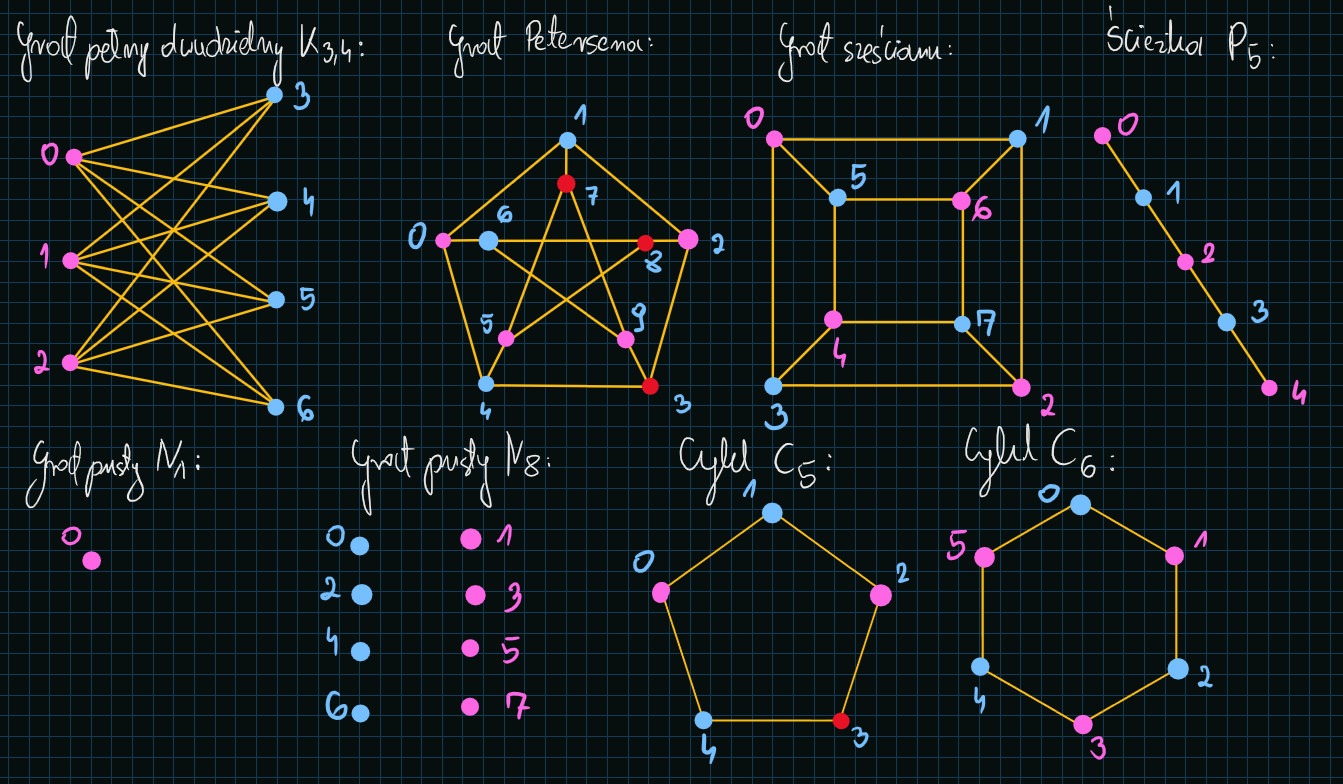

##### Pełny dwudzielny $ K_{3,4} $:

In [39]:
E = [(i, j) for i in range(3) for j in range(3, 7)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[3, 4, 5, 6]
[3, 4, 5, 6]
[3, 4, 5, 6]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
(3, [(0, 3), (1, 4), (2, 5)])


##### Graf Petersena:

In [40]:
E = [(0, 1), (0, 6), (0, 4), (1, 7), (1, 2), (2, 8), (2, 3), (3, 4), 
     (3, 9), (4, 5), (6, 8), (8, 5), (5, 7), (7, 9), (9, 6)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 6, 4]
[0, 7, 2]
[1, 8, 3]
[2, 4, 9]
[0, 3, 5]
[4, 8, 7]
[0, 8, 9]
[1, 5, 9]
[2, 6, 5]
[3, 7, 6]
(-1, [])


##### Graf sześcianu (kostka $ Q_3 $):

In [41]:
E = [(0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4), (0, 5), (1, 6), (2, 7), (3, 4)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 3, 5]
[0, 2, 6]
[1, 3, 7]
[2, 0, 4]
[5, 7, 3]
[4, 6, 0]
[5, 7, 1]
[6, 4, 2]
(4, [(0, 1), (2, 3), (4, 5), (6, 7)])


##### Ścieżka $ P_5 $:

In [42]:
E = [(i, i + 1) for i in range(4)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1]
[0, 2]
[1, 3]
[2, 4]
[3]
(2, [(0, 1), (2, 3)])


##### Ścieżka $ P_6 $:

In [43]:
E = [(i, i + 1) for i in range(5)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1]
[0, 2]
[1, 3]
[2, 4]
[3, 5]
[4]
(3, [(0, 1), (2, 3), (4, 5)])


##### Cykl $ C_5 $:

In [44]:
E = [(i, (i + 1) % 5) for i in range(5)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 4]
[0, 2]
[1, 3]
[2, 4]
[3, 0]
(-1, [])


##### Cykl $ C_6 $:

In [45]:
E = [(i, (i + 1) % 6) for i in range(6)]
G = undirected_graph_list(E)

print(*G, sep='\n')
print(maximum_association(G))

[1, 5]
[0, 2]
[1, 3]
[2, 4]
[3, 5]
[4, 0]
(3, [(0, 1), (2, 3), (4, 5)])
